In [ ]:
# @title
!unzip val_files.zip

In [ ]:
# @title
import re
import pandas as pd

# Function to extract image path and corresponding probabilities
def extract_data(file_content):
    image_data = []

    # Define regex patterns for extracting the relevant information
    merged_pattern = r'Merged predictions for (.+): \[(.+)\]'
    mean_pattern = r'Mean predictions for (.+): \[(.+)\]'
    dev_pattern = r'Dev predictions for (.+): \[(.+)\]'

    lines = file_content.splitlines()

    for i, line in enumerate(lines):
        merged_match = re.search(merged_pattern, line)
        if merged_match:
            image_path = merged_match.group(1)
            merged_probs = [float(x) for x in merged_match.group(2).split()]

            # Check for corresponding mean and dev predictions
            if i+1 < len(lines):
                mean_match = re.search(mean_pattern, lines[i+1])
                dev_match = re.search(dev_pattern, lines[i+2])

                if mean_match and dev_match:
                    # Ensure the image paths match before extracting data
                    if mean_match.group(1) == merged_match.group(1) and dev_match.group(1) == merged_match.group(1):
                        mean_probs = [float(x) for x in mean_match.group(2).split()]
                        dev_probs = [float(x) for x in dev_match.group(2).split()]

                        image_data.append({
                            "Image": image_path,
                            "Max Probability Grass": merged_probs[0],
                            "Max Probability Clover": merged_probs[1],
                            "Max Probability Soil": merged_probs[2],
                            "Max Probability Dung": merged_probs[3],
                            "Mean Probability Grass": mean_probs[0],
                            "Mean Probability Clover": mean_probs[1],
                            "Mean Probability Soil": mean_probs[2],
                            "Mean Probability Dung": mean_probs[3],
                            "Dev Probability Grass": dev_probs[0],
                            "Dev Probability Clover": dev_probs[1],
                            "Dev Probability Soil": dev_probs[2],
                            "Dev Probability Dung": dev_probs[3],
                        })

    return image_data


In [ ]:
# @title
def parse(file_path, output_csv_path):
  with open(file_path, 'r') as file:
      file_content = file.read()

  # Extract the data
  image_data = extract_data(file_content)

  # Convert to DataFrame
  df = pd.DataFrame(image_data)

  # Save to CSV
  df.to_csv(output_csv_path, index=False)

  print(f"CSV file has been saved as {output_csv_path}")

In [ ]:
# @title
parse('val_inaturalist2.txt', 'inaturalist_predictions.csv')

In [ ]:
# @title
parse('val_densenet2.txt', 'densenet_predictions.csv')

In [ ]:
# @title
parse('val_ensemble.txt', 'ensemble_predictions.csv')

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Load your CSV file into a DataFrame
file_path = 'ensemble_predictions.csv'  # Replace this with the path to your CSV file
df = pd.read_csv(file_path)

# Function to extract DOMIN score from the image path
def extract_domin_score(image_path):
    match = re.search(r'Validation-DOMIN/(\d+)/', image_path)
    if match:
        return int(match.group(1))
    return None

# Apply the function to create a new column for the DOMIN score
df['Domin Score'] = df['Image'].apply(extract_domin_score)

# Filter out rows where the DOMIN score could not be extracted (i.e., None values)
df = df.dropna(subset=['Domin Score'])

# Group by the DOMIN score and calculate the mean and variance of the Mean Probability Clover for each group
domin_stats = df.groupby('Domin Score')['Mean Probability Clover'].agg(['mean', 'var'])

# Calculate standard deviation
domin_stats['std'] = domin_stats['var']**0.5

# Plotting the graph with shaded area for standard deviation
plt.figure(figsize=(12, 8))
plt.plot(domin_stats.index, domin_stats['mean'], marker='o', linestyle='-', color='b', markersize=8)

# Shading the area for one standard deviation
plt.fill_between(
    domin_stats.index,
    domin_stats['mean'] - domin_stats['std'],
    domin_stats['mean'] + domin_stats['std'],
    color='blue',
    alpha=0.2,
    label='1 Std Dev'
)

# Adding labels and titles
plt.title('Domin Score vs Mean of Mean Probability Clover (with 1 Std Dev)', fontsize=16)
plt.xlabel('Domin Score', fontsize=14)
plt.ylabel('Mean of Mean Probability Clover', fontsize=14)
plt.xticks(domin_stats.index)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

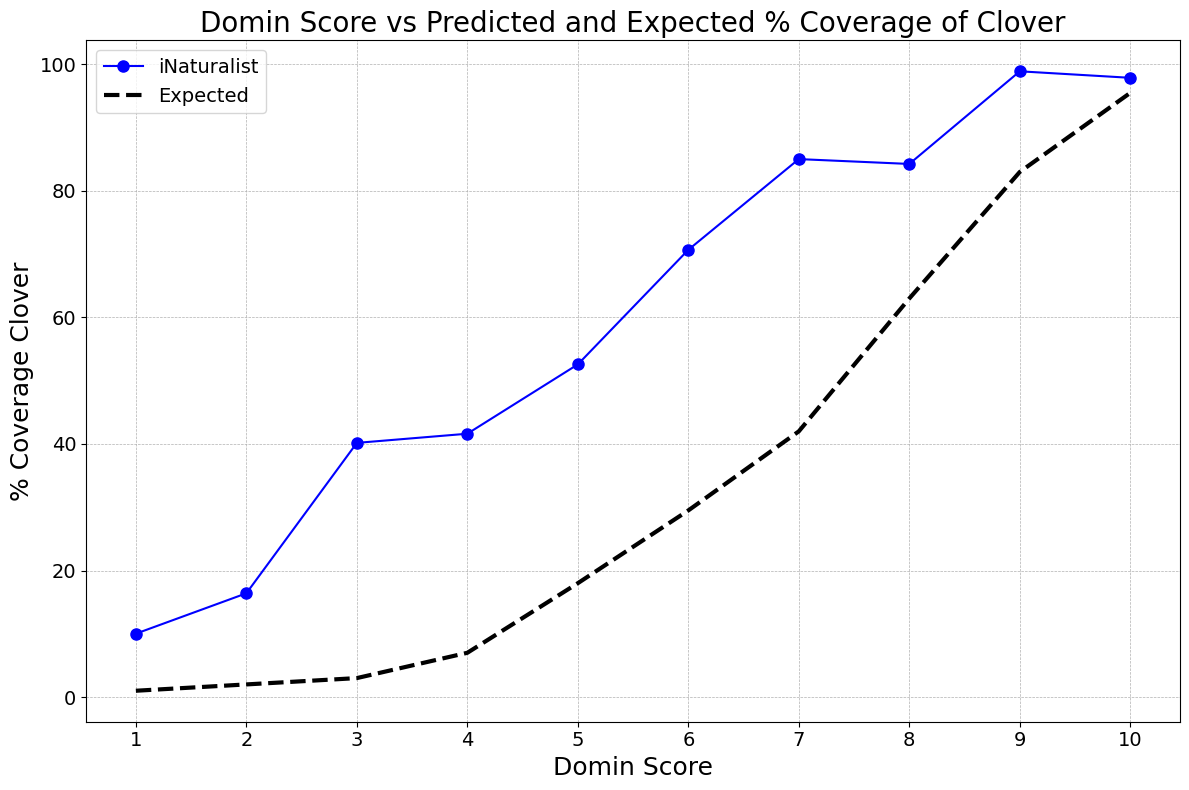

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# List of CSV file paths
csv_files = ['inaturalist_predictions.csv']  # Replace with your actual file paths
dataset_names = ['iNaturalist']  # Replace with your dataset names
colors = ['blue', 'green', 'red']  # Ensure the same number of colors as datasets

# Expected percentage cover midpoints for each DOMIN score
expected_cover_midpoints = {
    10: 95.5,
    9: 83,
    8: 63,
    7: 42,
    6: 29.5,
    5: 18,
    4: 7,
    3: 3,
    2: 2,
    1: 1
}

# Plotting setup
plt.figure(figsize=(12, 8))

for i, file_path in enumerate(csv_files):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Function to extract DOMIN score from the image path
    def extract_domin_score(image_path):
        match = re.search(r'Validation-DOMIN/(\d+)/', image_path)
        if match:
            return int(match.group(1))
        return None

    # Apply the function to create a new column for the DOMIN score
    df['Domin Score'] = df['Image'].apply(extract_domin_score)

    # Filter out rows where the DOMIN score could not be extracted (i.e., None values)
    df = df.dropna(subset=['Domin Score'])

    # Group by the DOMIN score and calculate the mean and variance of the Mean Probability Clover for each group
    domin_stats = df.groupby('Domin Score')['Mean Probability Clover'].agg(['mean', 'var'])

    # Calculate standard deviation
    domin_stats['std'] = domin_stats['var']**0.5

    # Plotting the graph with shaded area for standard deviation
    plt.plot(
        domin_stats.index,
        domin_stats['mean'] * 100,
        marker='o',
        linestyle='-',
        color=colors[i],
        markersize=8,
        label=f'{dataset_names[i]}'
    )

    # Shading the area for one standard deviation
    # plt.fill_between(
    #     domin_stats.index,
    #     100 * (domin_stats['mean'] - domin_stats['std']),
    #     100 * (domin_stats['mean'] + domin_stats['std']),
    #     color=colors[i],
    #     alpha=0.2
    # )

# Plotting the reference line for expected percentage cover midpoints
domin_scores = np.arange(1, 11)
expected_covers = [expected_cover_midpoints[score] for score in domin_scores]

plt.plot(
    domin_scores,
    expected_covers,
    linestyle='--',
    color='black',
    linewidth=3,
    label='Expected'
)

# Adding labels, titles, and legend
plt.title('Domin Score vs Predicted and Expected % Coverage of Clover', fontsize=20)
plt.xlabel('Domin Score', fontsize=18)
plt.ylabel('% Coverage Clover', fontsize=18)
plt.xticks(np.arange(1, 11), fontsize=14)  # Assuming DOMIN scores are from 1 to 10
plt.yticks(fontsize=14)  # Assuming DOMIN scores are from 1 to 10
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()
